# Chapter 2: Our First Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image


## Setting up DataLoaders

We'll use the built-in dataset of `torchvision.datasets.ImageFolder` to quickly set up some dataloaders of downloaded cat and fish images. 

`check_image`  is a quick little function that is passed to the `is_valid_file` parameter in the ImageFolder and will do a sanity check to make sure PIL can actually open the file. We're going to use this in lieu of cleaning up the downloaded dataset.


In [2]:
import imageio
import matplotlib.pyplot as plt
import os
import numpy as np

baseDir = os.getcwd()
baseFolders = ['test','train','val']
dataFolders = ['fish','cat']
for k1 in np.arange(0,3):
    for k2 in np.arange(0,2):
        currDir = (baseDir+"\\"+baseFolders[k1]+"\\"+dataFolders[k2])
        #print(currDir)
        currDir_files = os.listdir(currDir)
        #len(currDir_files)
        for k in np.arange(0,len(currDir_files)): # enumerate(currDir_files):
            currFile = os.path.join(currDir,currDir_files[k])
            if (os.path.getsize( currFile)<4000):
                os.remove(currFile)
            else:
                try:
                    #print(currFile) 
                    fileHandler = open(currFile, "r")
                    im = imageio.imread(currFile)
                except:
                    fileHandler.close()
                    #im.close()
                    print(currFile)                  
                    print(fileHandler.closed)
                    #os.close(fileHandler)
                    #print(fileHandler.closed)
                    #fileHandler = close(currFile, "r")
                    #os.close(currFile)
                    #os.remove(currFile)

C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\train\fish\chum.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\train\fish\firstcoho.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\train\fish\image.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\train\fish\MDcohosalmon091203.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\train\fish\pasagshakcoho2.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\val\fish\coho&spring.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2\val\fish\fish_cohosalmon_1.jpg
True
C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\

C:\Users\sbbk034\OneDrive - City, University of London\Documents\GitHub\pytorchupandrunning\chapter2./val/fish/100_1422.JPG


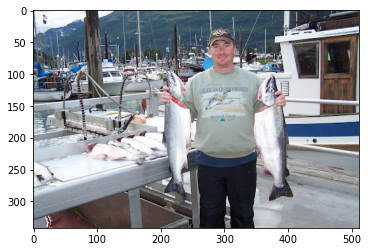

In [95]:

filename = baseDir+ "./val/fish/100_1422.JPG"
print(filename)
im = Image.open(filename)
plt.imshow(im)

In [46]:
def check_image(path):
    try:
        im = Image.open(path)
        #print("A -----"+path)
        return True
    except:
        print("B ----- -----"+path)
        return False

Set up the transforms for every image:

* Resize to 64x64
* Convert to tensor
* Normalize using ImageNet mean & std


In [47]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])



In [57]:
train_data_path = './train/'
# when using is_valid_file NOTHING WORKS
#train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

In [58]:
train_data

Dataset ImageFolder
    Number of datapoints: 797
    Root location: ./train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [59]:
val_data_path = "./val/"
# when using is_valid_file NOTHING WORKS
# val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)
val_data

Dataset ImageFolder
    Number of datapoints: 106
    Root location: ./val/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [60]:
test_data_path = "./test/"
#test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, is_valid_file=check_image) 
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms) 
test_data

Dataset ImageFolder
    Number of datapoints: 160
    Root location: ./test/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [61]:
batch_size=64

In [83]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 
train_data_path

'./train/'

('./train/cat\\131545070_970a905e5c.jpg', 0)


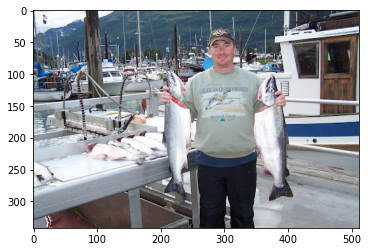

In [92]:
print(train_data_loader.dataset.imgs[51])

#filename = "./val/fish/100_1422.JPG"
#print(filename)
im = Image.open(filename)
plt.imshow(im)


## Our First Model, SimpleNet

SimpleNet is a very simple combination of three Linear layers and ReLu activations between them. Note that as we don't do a `softmax()` in our `forward()`, we will need to make sure we do it in our training function during the validation phase.

In [69]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [70]:
simplenet = SimpleNet()

## Create an optimizer

Here, we're just using Adam as our optimizer with a learning rate of 0.001.

In [71]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

## Copy the model to GPU

Copy the model to the GPU if available.

In [72]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

## Training 

Trains the model, copying batches to the GPU if required, calculating losses, optimizing the network and perform validation for each epoch.

In [73]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [74]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=5, device=device)

<ipython-input-73-f38d79bc5988>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 0, Training Loss: 3.07, Validation Loss: 4.46, accuracy = 0.34
Epoch: 1, Training Loss: 2.35, Validation Loss: 2.37, accuracy = 0.40
Epoch: 2, Training Loss: 1.75, Validation Loss: 0.59, accuracy = 0.75
Epoch: 3, Training Loss: 0.52, Validation Loss: 0.90, accuracy = 0.63
Epoch: 4, Training Loss: 0.54, Validation Loss: 0.71, accuracy = 0.70


## Making predictions

Labels are in alphanumeric order, so `cat` will be 0, `fish` will be 1. We'll need to transform the image and also make sure that the resulting tensor is copied to the appropriate device before applying our model to it.

In [77]:
labels = ['cat','fish']

img = Image.open("./val/cat/2090435515_841c4a1b6a.jpg") 
img = img_transforms(img).to(device)


prediction = F.softmax(simplenet(img))
prediction = prediction.argmax()
print(labels[prediction]) 

fish


<ipython-input-77-cbe938b8a21f>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prediction = F.softmax(simplenet(img))


## Saving Models

We can either save the entire model using `save` or just the parameters using `state_dict`. Using the latter is normally preferable, as it allows you to reuse parameters even if the model's structure changes (or apply parameters from one model to another).

In [ ]:
torch.save(simplenet, "/tmp/simplenet") 
simplenet = torch.load("/tmp/simplenet")    


In [ ]:
torch.save(simplenet.state_dict(), "/tmp/simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("/tmp/simplenet")
simplenet.load_state_dict(simplenet_state_dict)   